In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import tensorflow as tf
import os ,sys, platform
import cosmopower as cp
import time

In [2]:
#parameter
par = {"H0":67.36, "ombh2":0.02237, "omch2":0.1200, "mnu":0.06, "omk":0, "tau":0.0544,"As":2.101e-9, "ns":0.965, "r":0} 

#params for cosmopower
params = {'omega_b': [par["ombh2"]],
          'omega_cdm': [par["omch2"]],
          'h': [par["H0"]/100],
          'tau_reio': [par["tau"]],
          'n_s': [par["ns"]],
          'ln10^{10}A_s': [np.log( 10**10 * par["As"])],
          }

In [10]:
def Cosmo(xe,ze):
    if xe == 'TT':
        tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995]
    elif xe == 'TE':
        te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995]
    else:
        None
    return CO

def Camb_pp(ell,ell_max,parameter,x,lens_accuracy=0):
    #camb model pars
    pars = camb.CAMBparams()
    pars.set_cosmology(H0 = par["H0"], ombh2=par["ombh2"], omch2=par["omch2"], mnu=par["mnu"], omk=par["omk"], tau=par["tau"])
    pars.InitPower.set_params(As=par["As"], ns=par["ns"], r=par["r"])
    pars.set_for_lmax(ell_max-1, lens_potential_accuracy=float(lens_accuracy));
    #camb result and power spectra
    camb_results = camb.get_results(pars)
    powers = camb_results.get_cmb_power_spectra(pars, CMB_unit="muK")#,raw_cl=True)
    
    if x == 'TT':
        #CAMB TT
        cambq = powers['lensed_scalar'][:, 0][2:ell_max]
    elif x == 'EE':
        #CAMB EE
        cambq = powers['lensed_scalar'][:, 1][2:ell_max]
    elif x == 'TE':
        #CAMB TE
        cambq = powers['lensed_scalar'][:, 3][2:ell_max]
    else:
        #CAMB TE EE
        cambq = None  
    return cambq 
def chi2(tre,teu,trb,pred):
    u = (tre - pred)**2
    b = (teu+ trb)**2
    c = u/b
    chi = np.sum(c)
    return chi

In [5]:
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)

(200,)
0.8
8452.392101287842 ms


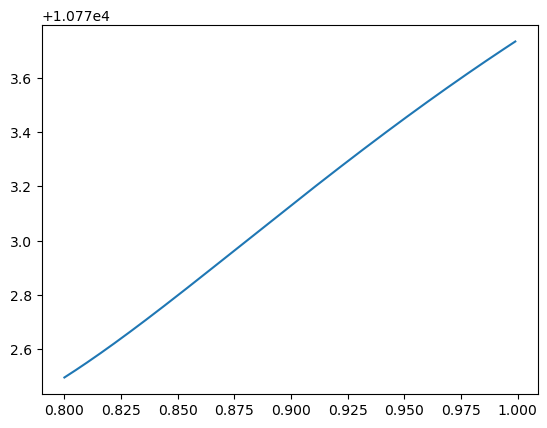

In [108]:
nsa = time.time()
chi2_arr=[]
omch_2_arr = np.arange(0.8,1,0.001)
for val in omch_2_arr:    
    #params for cosmopower
    params = {'omega_b': [0.02237],
              'omega_cdm': [0.1200],
              'h': [67.36/100],
              'tau_reio': [0.0544],
              'n_s': [val],
              'ln10^{10}A_s': [3.101],
              }
    pred = Cosmo('EE',params)
    chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    chi2_arr.append(chi)
    
plt.plot(omch_2_arr,chi2_arr)
asd = np.argmin(chi2_arr)
vals = omch_2_arr[asd]

nen = time.time()
print(np.shape(omch_2_arr))
print(vals)
print((nen-nsa)* 10**3, "ms")

(10,)

0.021 0.111 67.22 0.45 0.947 3.02
77.10528373718262 ms


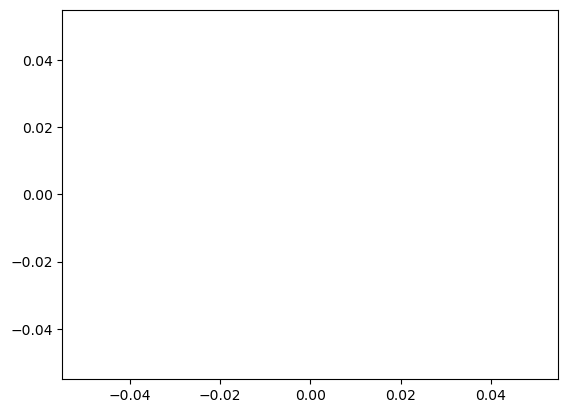

In [105]:
#parameter
par = {"H0":67.36, "ombh2":0.02237, "omch2":0.1200, "mnu":0.06, "omk":0, "tau":0.0544,"As":2.101e-9, "ns":0.965, "r":0}
en =10
'''omega_b = np.random.uniform(low=0.01875, high=0.02625, size=(10,))
omega_cdm = np.random.uniform(low=0.05, high=0.255, size=(10,))
h = np.random.uniform(low=0.64, high=0.82, size=(10,))
tau_reio = np.random.uniform(low=0.01, high=0.1, size=(10,))
n_s = np.random.uniform(low=0.84, high=1.1, size=(10,))
lnAs = np.random.uniform(low=1.61, high=3.91, size=(10,))'''
omega_b = np.arange(0.021,0.023,0.0002)
omega_cdm = np.arange(0.111,0.13,0.002)
h = np.arange(67.22,67.4,0.02)
tau_reio = np.arange(0.45,0.65,0.02)
n_s = np.arange(0.947,0.965,0.002)
lnAs = np.arange(3.02,3.2,0.02)

nsa = time.time()
chi2_arr=[]
params = {'omega_b': omega_b,
                'omega_cdm': omega_cdm,
                'h': h,
                'tau_reio': tau_reio,
                'n_s': n_s,
                'ln10^{10}A_s': lnAs,
                }
pred = Cosmo('TT',params)
for i in range(en):
    ened = pred[i]
    chi = chi2(Dl_TT,Dl_TT_err_up,Dl_TT_err_bot,ened)
    chi2_arr.append(-chi)
    
plt.plot(h,chi2_arr)
asd =0 
asd = np.argmin(chi2_arr)
#vals = params[asd]
nen = time.time()
print(np.shape(chi2_arr))
print()
print(params['omega_b'][asd],params['omega_cdm'][asd],params['h'][asd],params['tau_reio'][asd],params['n_s'][asd],params['ln10^{10}A_s'][asd],)
print((nen-nsa)* 10**3, "ms")

In [97]:
omega_b = np.arange(0.021,0.023,0.0002)
omega_cdm = np.arange(0.111,0.13,0.002)
h = np.arange(67.22,67.4,0.02)
tau_reio = np.arange(0.45,0.65,0.02)
n_s = np.arange(0.947,0.965,0.002)
lnAs = np.arange(3.02,3.2,0.02)

print(np.shape(omega_b))
print(np.shape(omega_cdm))
print(np.shape(h))
print(np.shape(tau_reio))
print(np.shape(n_s))
print(np.shape(lnAs))


(10,)
(10,)
(10,)
(10,)
(10,)
(10,)


In [12]:
pred = Cosmo('EE',params)
print(pred)
print(Dl_EE)

[3.26733552e-02 2.10111529e-02 1.09862096e-02 ... 1.44014317e-05
 1.43071087e-05 1.42130122e-05]
[ 1.10437000e-01  3.78300000e-02  1.75461100e-02 ...  1.74441172e+02
 -2.52188032e+02 -1.83010648e+02]
